<center> <h1> Mind Map Generator </h1> </center>
<h3> Siddharth Thakur – 20BCE1144 </h3> </center>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.cluster.util import cosine_distance
from nltk.corpus import stopwords
from rake_nltk import Rake

from bs4 import BeautifulSoup
import networkx as nx
import requests
import re
import heapq

In [2]:
stop_words = stopwords.words('english')

### Web Scrapping

In [3]:
def scrape_data(URL):
    html_page = requests.get(URL).text
    soup = BeautifulSoup(html_page, 'lxml')
    paraContent = soup.find_all('p')
    paragraph = ""
    for para in paraContent:
        paragraph += para.text
    paragraph = re.sub(r'\[[0-9a-zA-Z]*\]', ' ', paragraph)
    paragraph = re.sub(r"(  |\r|\n|\t)", ' ', paragraph)
    
    return paragraph

### Data Cleaning

In [4]:
def clean_text(text):
    space_pattern = r"(  |\r|\n|\t)"
    citation_pattern = r'\[[0-9a-zA-Z]*\]'
    text = re.sub(space_pattern, " ", text)
    text = re.sub(citation_pattern, "", text)
    
    return text

### LDA 

In [5]:
def lemmatization(texts, stop_words ,allowed_postags=['NN', 'NNS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS']):
    #We are allowing only nouns, adjectives, verbs, adverb and its form
    # Tokenizing, POS and Lemmatization
    texts_out = []
    lemmatizer = WordNetLemmatizer()
    for text in texts:
        new_text = []
        words = nltk.word_tokenize(text) #Tokenizing
        tagged_words = nltk.pos_tag(words) #POS
        for tags in tagged_words:
            # Not a stop word and its a allowed POS Tag
            if((tags[0] not in stop_words) and (tags[1] in allowed_postags)):
                #Not a stop word and its a allowed POS
                new_text.append(lemmatizer.lemmatize(tags[0])) # Lemmatization
        final_text = " ".join(new_text)
        texts_out.append(final_text)
    
    return texts_out

In [6]:
def group_sentences(sentences, group_len = 3):
    #Grouping sentences so that it makes sense - Here we randomly chose 3 as threshold in one group.
    new_sentences = []
    for idx in range(0, len(sentences), group_len):
        new_sent = ''
        i = idx
        while i<len(sentences) and i<idx+3:
            new_sent += sentences[i]
            i += 1
        new_sentences.append(new_sent)
    return new_sentences

In [7]:
def gen_words(texts):
    #Basic preprocessing - Tokenization, Lowercasing, Filtering (Short or Long words), Stopword removal and Lemmatization 
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True) #Deacc is used to remove accents
        final.append(new)
    #Returns tokeized list of grouped sentences
    return final

In [8]:
def make_bigrams(bigram, texts):
    #Takes on preprocessed sentence which is tokenized etc, as input and outputs bigrams
    return [bigram[doc] for doc in texts]

In [9]:
def make_trigrams(trigram, bigram, texts):
    #Takes on preprocessed sentence which is tokenized etc, (with bigrams) as input and outputs trigrams
    return [trigram[bigram[doc]] for doc in texts]

In [10]:
def get_topic_index(lda_model):
    cluster_idx = lda_model.show_topics()
    topics = {}
    present_topics = []
    for term in cluster_idx:
        terms = term[1].split('+')
        idx = 0
        element = terms[idx].split('*')[1]
        element = element.strip()[1:-1]
        while(element in present_topics):
            idx += 1
            element = terms[idx].split('*')[1]
            element = element.strip()[1:-1]
        present_topics.append(element)
        topics[term[0]] = element
        
    return topics

In [11]:
def get_grouped_sentences(lda_model, corpus, sentences):
    # Finding importance and the topic and storing it
    grouped_sentences = {k: '' for k in range(0, 10)}
    lda_corpus = lda_model[corpus]
    cluster_index_list = [doc for doc in lda_corpus]
    # For each group we are taking the token that has highest importance
    for idx in range(0, len(cluster_index_list)):
        indexes = cluster_index_list[idx]
        if(len(indexes) == 1):
            grouped_sentences[indexes[0][0]] += sentences[idx]
        else:
            max_prob = 0
            best_index = 0
            for index in indexes:
                prob = index[1]
                if(prob > max_prob):
                    max_prob = prob
                    best_index = index[0]
            grouped_sentences[best_index] += sentences[idx]

    return grouped_sentences

In [12]:
def create_topics(text, sentence_group=3, num_topics=10):
    stop_words = stopwords.words('english')
    sentences = nltk.sent_tokenize(text) #Finding EOS

    grouped_sentences = group_sentences(sentences, sentence_group)
    lemmatized_text = lemmatization(grouped_sentences, stop_words)
    data_words = gen_words(lemmatized_text)

    #Tokenization, Collocation detection, Phrase modeling
    #Detecting Phrases
    bigram_phrases = gensim.models.Phrases(data_words, min_count=3, threshold=25)
    trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=25)

    #Phrase modeling
    bigram = gensim.models.phrases.Phraser(bigram_phrases)
    trigram = gensim.models.phrases.Phraser(trigram_phrases)
    
    data_bigrams = make_bigrams(bigram, data_words)
    data_bigrams_trigrams = make_trigrams(trigram, bigram, data_bigrams)

    # id2word object is a dictionary that maps each word in the corpus to a unique integer id
    id2word = corpora.Dictionary(data_bigrams_trigrams)
    texts = data_bigrams_trigrams
    # doc2bow converts each document into a bag-of-words - a list of tuples where each tuple represents a word in the document and its frequency).
    corpus = [id2word.doc2bow(text) for text in texts] 

    # TF-IDF is often used to represent the importance of a term in a document or a corpus of documents. 
    # It is calculated by multiplying two values: the term frequency (TF) and the inverse document frequency (IDF).
    # Inverse document frequency (IDF) measures how important a term is in a corpus of documents. 
    # IDF is calculated as the logarithm of the total number of documents in the corpus divided by the number of documents that contain the term.
    tfidf = TfidfModel(corpus=corpus, id2word=id2word)
    low_value = 0.03
    words = []
    words_missing_in_tfid = []
    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = []
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words + words_missing_in_tfid
        for item in drops:
            words.append(id2word[item])
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]     
        corpus[i] = new_bow
        #We make a new corpus based on TF-IDF score - remove words with 0 or less than 0.3 score

    # Creating LDA Model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics,
                                               random_state=42,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto')
    
    # LDA inbuilt function is not giving proper topics for grouped texts so we are using custom function
    topics = get_topic_index(lda_model)

    return [get_grouped_sentences(lda_model, corpus, grouped_sentences), topics]

### Text Summarization

In [13]:
def get_important_sentences(data):
    sentence_tokens = nltk.sent_tokenize(data)
    stop_words = nltk.corpus.stopwords.words('english')
    word_frequencies = {}
    word_tokens = nltk.word_tokenize(data)
    #If the word is not a stop word and is not in the dict, add it or increase the frequency by 1
    for word in word_tokens:
        if word not in stop_words:
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
                
    # Weighted Frequencies for scaling purpose wrt the highest occuring token. So, that we will know the relative frequency
    maximum_frquency_word = max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word] = (word_frequencies[word]/maximum_frquency_word)
    
    # Sentence Score - Adding the frequencies of the words present in a sentence
    sentence_scores = {}
    for sentence in sentence_tokens:
        for word in nltk.word_tokenize(sentence.lower()):
            if word in word_frequencies.keys():
                if(len(sentence.split(" ")) < 30):
                    if sentence not in sentence_scores.keys():
                        sentence_scores[sentence] = word_frequencies[word]
                    else:
                        sentence_scores[sentence] += word_frequencies[word]
    
    # Selecting top 25 sentence based on the score
    top_sentences = heapq.nlargest(25, sentence_scores, key=sentence_scores.get)
    result = []
    for sentence in top_sentences:
        result.append(nltk.word_tokenize(sentence))
    
    return result

In [14]:
def sentence_similarity(sent1, sent2, stop_words):
    # Cosine similarity
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
    all_words = list((set(sent1+sent2)))
    
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    for w in sent1:
        if w not in stop_words:
            vector1[all_words.index(w)] += 1
    for w in sent2:
        if w not in stop_words:
            vector2[all_words.index(w)] += 1
    
    return 1-cosine_distance(vector1, vector2)

In [15]:
def gen_sim_matrix(sentences, stop_words):
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if(idx1 == idx2):
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    
    return similarity_matrix

In [16]:
def generate_summary(data, top_n=5):
    sentences = get_important_sentences(data)
    summarized_text = []
    sentence_similarity_matrix = gen_sim_matrix(sentences, stop_words)
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph)
    ranked_sentences = sorted(((scores[i], s) for i,s in enumerate(sentences)), reverse=True)
    upper_limit = min(len(ranked_sentences), top_n)
    for i in range(upper_limit):
        summarized_text.append(" ".join(ranked_sentences[i][1]))
    summary = " ".join(summarized_text)
    return summary

### Get Keywords

In [17]:
def set_threshold(phrases):
    scores = []
    for phrase in phrases:
        scores.append(phrase[0])
    # 65th percentile is used which means that only the top 35% of the phrases will be included.
    threshold = np.perce-ntile(scores, 65)
    
    return threshold

In [18]:
def get_common_phrases(phrase_list, max_nodes=5):
    common_phrases = []
    for group1 in phrase_list:
        flag = 0
        count_common_phrases = 0
        # Comparing each phrase in the group with all other groups of text
        # If a phrase is found to be common with any phrase in another group, its appended
        for phrase1 in group1:
            for group2 in phrase_list:
                if(group1 != group2):
                    for phrase2 in group2:
                        if(phrase1[1] == phrase2[1]):
                            common_phrases.append([phrase1[1], phrase_list.index(group1), phrase_list.index(group2)])
                            count_common_phrases += 1
                            if(count_common_phrases == max_nodes):
                                flag = 1
                                break
                    if(flag):
                        break
            if(flag):
                break
                       
    return common_phrases

In [19]:
def get_keywords(grouped_text, max_nodes=5):
    phrases_list = []
    for idx in grouped_text:
        if(grouped_text[idx]):
            #We use Rapid Automatic Keyword Extraction (RAKE) Algorithm to extract keywords
            rake_model = Rake()
            # Extract keywords from sentences
            rake_model.extract_keywords_from_text(grouped_text[idx])
            #Gives score and phrases - tuple like (score: phrase)
            phrases = rake_model.get_ranked_phrases_with_scores()
            phrases_list.append(phrases)
        else:
            phrases_list.append([])
    final_keywords = get_best_phrases(phrases_list, max_nodes)
    common_list = get_common_phrases(phrases_list, max_nodes//2)
    for phrase in common_list:
        keyword = phrase[0]
        if(keyword not in final_keywords[phrase[1]]):
            final_keywords[phrase[1]].append(keyword)
        if(keyword not in final_keywords[phrase[2]]):
            final_keywords[phrase[2]].append(keyword)
    return final_keywords

In [20]:
def get_best_phrases(phrase_list, max_nodes=5):
    final_phrases = []
    for phrases in phrase_list:
        final_phrases_topic = []
        # Filtering out the phrases with scores below the threshold
        if(phrases):
            # Threshold - 65th Percentile
            threshold = set_threshold(phrases)
            for phrase in phrases:
                if(phrase[0] > math.floor(threshold)):
                    if(final_phrases_topic):
                        flag = 0
                        # Comparing each filtered phrase with the previously extracted phrases using cosine similarity
                        # Doing this to reduce keyords as much as possible and reduce repetations
                        for prev_phrase in final_phrases:
                            if(prev_phrase):
                                similarity = sentence_similarity(prev_phrase, phrase[1], stop_words)
                                if(similarity > 0.99):
                                    flag = 1
                                    break
                        if(not flag):
                            final_phrases_topic.append(phrase[1])
                    else:
                        final_phrases_topic.append(phrase[1])
        final_phrases.append(final_phrases_topic[:max_nodes])
    return final_phrases

In [21]:
def create_keywords_from_text(text, max_nodes=5, sentence_group=3, num_topics=10):
    #This function calls for LDA and grouping
    grouped_text, topics = create_topics(text, sentence_group, num_topics)
    #Calling function for extracting keywords from grouped sentences
    keywords = get_keywords(grouped_text, max_nodes)
    return [keywords, topics]

### Graph Generator using Topics and Keywords

In [22]:
def get_mindmap(keywords, topics):
    fig, ax = plt.subplots(figsize=(40,25))
    G = nx.Graph()
    G.add_node('Mind Map')
    # Removing characters thats not digit, letter or space
    reg_exp_pattern = "[^\d\w\s]"
    for idx in topics:
        main_topic = re.sub(reg_exp_pattern, '', topics[idx]).strip()
        # Adding Nodes
        G.add_edge('Mind Map', main_topic)
        topic_keywords = keywords[idx]
        for keyword in topic_keywords:
            keyword = re.sub(reg_exp_pattern, '', keyword).strip()
            if(keyword != re.sub(reg_exp_pattern, '', topics[idx]).strip()):
                G.add_edge(main_topic, keyword)

    nx.draw(G, with_labels=True, node_size=0, font_size = 16, )
    return plt

### Loading Text File

In [23]:
def load_text(file_name_path, encoding="utf8"):
    with open(file_name_path, encoding=encoding) as f:
        input_text = f.readlines()
        f.close()
    final_text = ''
    for text in input_text:
        final_text += text
    final_text = clean_text(final_text)
    
    return final_text

### Test - 1 (From Text Data)

In [24]:
with open(r"C:\Users\manig\Downloads\MM Data\sample_text2.txt", encoding="utf8") as f:
    input_text = f.readlines()
final_text = ''
for text in input_text:
    final_text += text

In [25]:
final_text = clean_text(final_text)
final_text

'The electric vehicle (EV) revolution is speeding up, but it can only go so far without the necessary infrastructure and technology. As thinking shifts from fossil fuels to all-electric, visions of a brighter, more optimistic world come into view. The UK government’s pledge to ban the sale of all new non-electric cars, including gasoline, diesel and hybrid vehicles from 2035, highlights the drive to end the nation’s contribution to Climate Change by 2050. If the 2035 target is to be met, we will all see evolutions in the transport and mobility routines that keep our lives moving. From using ultra-fast wireless charging to supporting the developing world by repurposing car batteries, WMG, at the University of Warwick, is delivering advances in electrification knowledge and technologies, which will enable the leap to an electric automotive future. So, for the now and the near future, what do we need to consider? Demand for EVs is surging in the UK and registrations of plug-in cars increa

In [26]:
text = generate_summary(final_text, top_n=40)
text

'So all in all you have a heavy , inefficient , cumbersome part . Because they are large , they are also heavy , which means the vehicle consumes more energy in a journey . Then , for safety reasons , currently affordable traction batteries need to have a high level of complexity . WMG ’ s involvement in the Nextrode project , funded by The Faraday Institution , is tackling this . As thinking shifts from fossil fuels to all-electric , visions of a brighter , more optimistic world come into view . So , for the now and the near future , what do we need to consider ? “ We aim to develop and integrate within a vehicle , a battery system based on a mixture of highly energy dense solid-state cells and high power density cells , ” says Greenwood . The electric vehicle ( EV ) revolution is speeding up , but it can only go so far without the necessary infrastructure and technology . The relationship between the charging infrastructure and the manufacture of the batteries is key , especially whe

In [27]:
keywords, topics = create_keywords_from_text(final_text, max_nodes=5, sentence_group=4)
keywords, topics

([['repurposing car batteries',
   'fast wireless charging',
   'electric automotive future',
   'near future',
   'using ultra',
   'supporting',
   'need'],
  [],
  ['key ,” explains greenwood',
   'class energy densities mean',
   'desired electric range capability',
   'efficient battery charging infrastructure',
   'long charging times',
   'need',
   'technology'],
  ['consumers ’ typical mobility behaviours',
   'short journeys somewhat counteracts',
   'robust battery charging infrastructure',
   'deliver 300 miles',
   'charging infrastructure',
   'technology',
   'consumers'],
  [],
  ['high power density cells ,” says greenwood',
   'currently affordable traction batteries need',
   'highly energy dense solid',
   'cumbersome part .“',
   'battery system based'],
  [],
  ['existing solutions .” although efficiency',
   'zero ’ strategy — aiming',
   'conventional vehicles offer today according',
   'includes project partner a123 systems',
   '£ 2m innovate uk',
   'supporti

In [28]:
for idx in range(len(keywords)):
    print(keywords[idx])

['repurposing car batteries', 'fast wireless charging', 'electric automotive future', 'near future', 'using ultra', 'supporting', 'need']
[]
['key ,” explains greenwood', 'class energy densities mean', 'desired electric range capability', 'efficient battery charging infrastructure', 'long charging times', 'need', 'technology']
['consumers ’ typical mobility behaviours', 'short journeys somewhat counteracts', 'robust battery charging infrastructure', 'deliver 300 miles', 'charging infrastructure', 'technology', 'consumers']
[]
['high power density cells ,” says greenwood', 'currently affordable traction batteries need', 'highly energy dense solid', 'cumbersome part .“', 'battery system based']
[]
['existing solutions .” although efficiency', 'zero ’ strategy — aiming', 'conventional vehicles offer today according', 'includes project partner a123 systems', '£ 2m innovate uk', 'supporting', 'consumers']
[]
[]


<module 'matplotlib.pyplot' from 'C:\\Users\\manig\\anaconda3\\envs\\nlp\\lib\\site-packages\\matplotlib\\pyplot.py'>

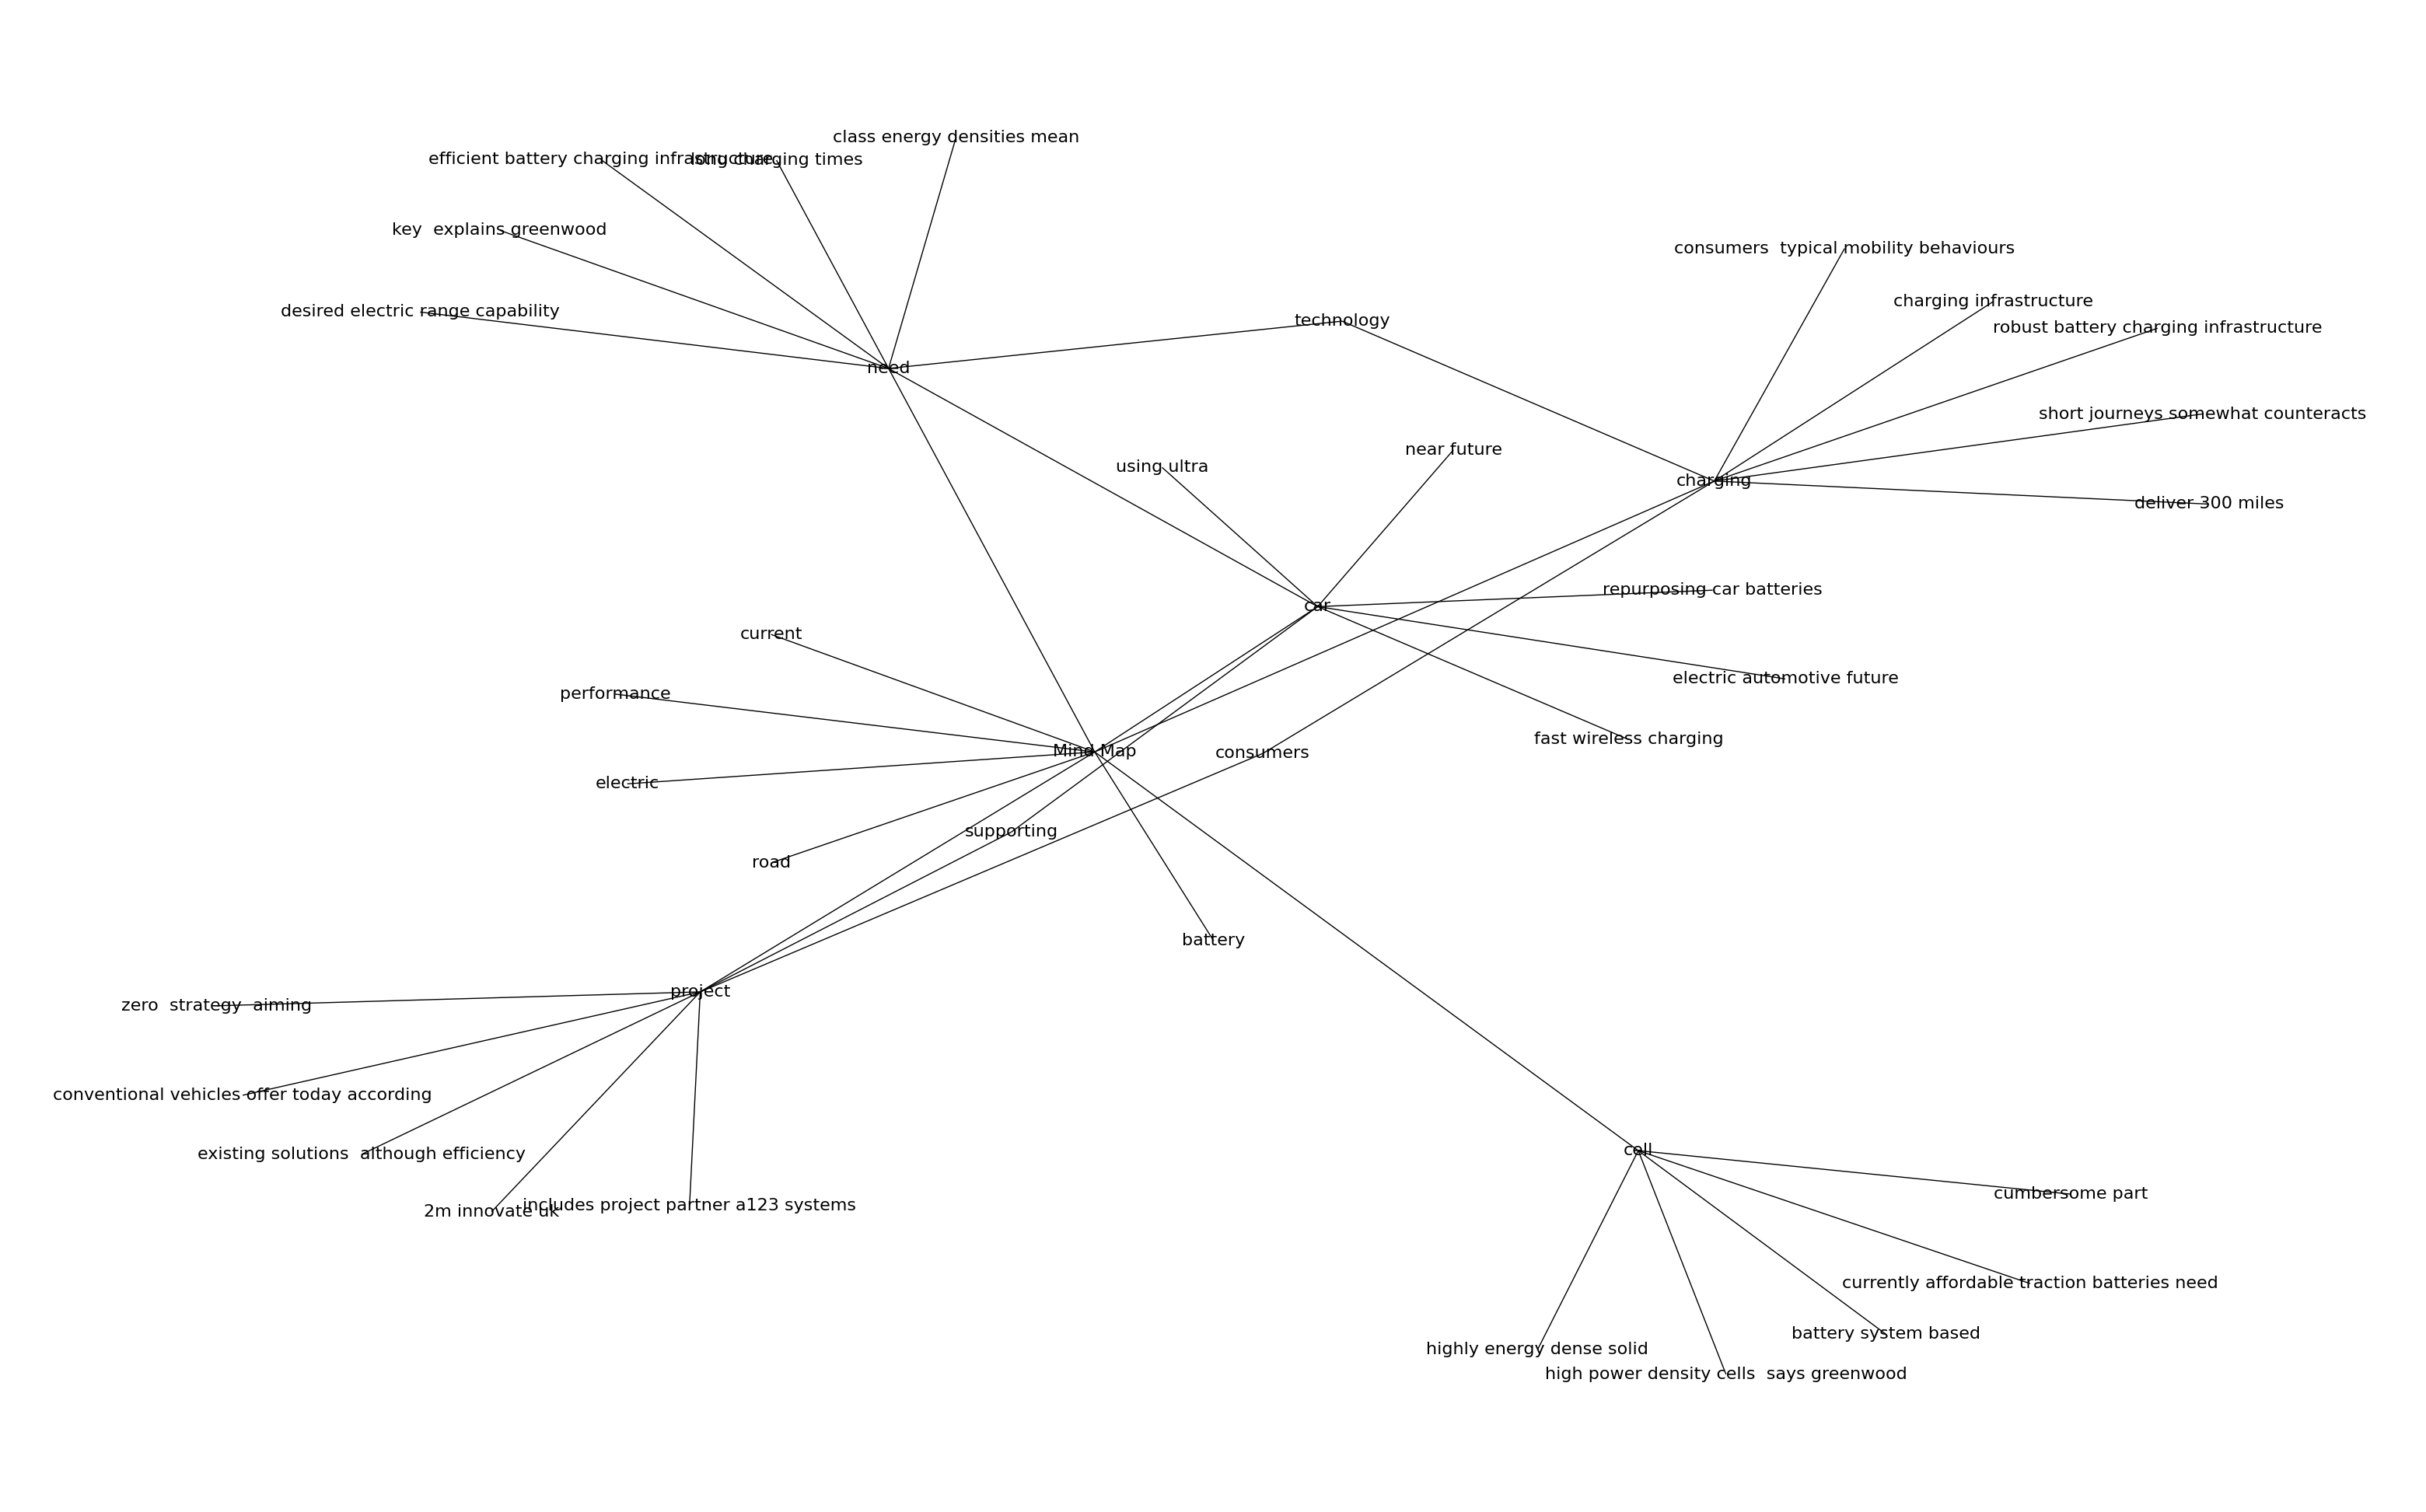

In [29]:
get_mindmap(keywords, topics)

### Test - 2 (From Text Data)

<module 'matplotlib.pyplot' from 'C:\\Users\\manig\\anaconda3\\envs\\nlp\\lib\\site-packages\\matplotlib\\pyplot.py'>

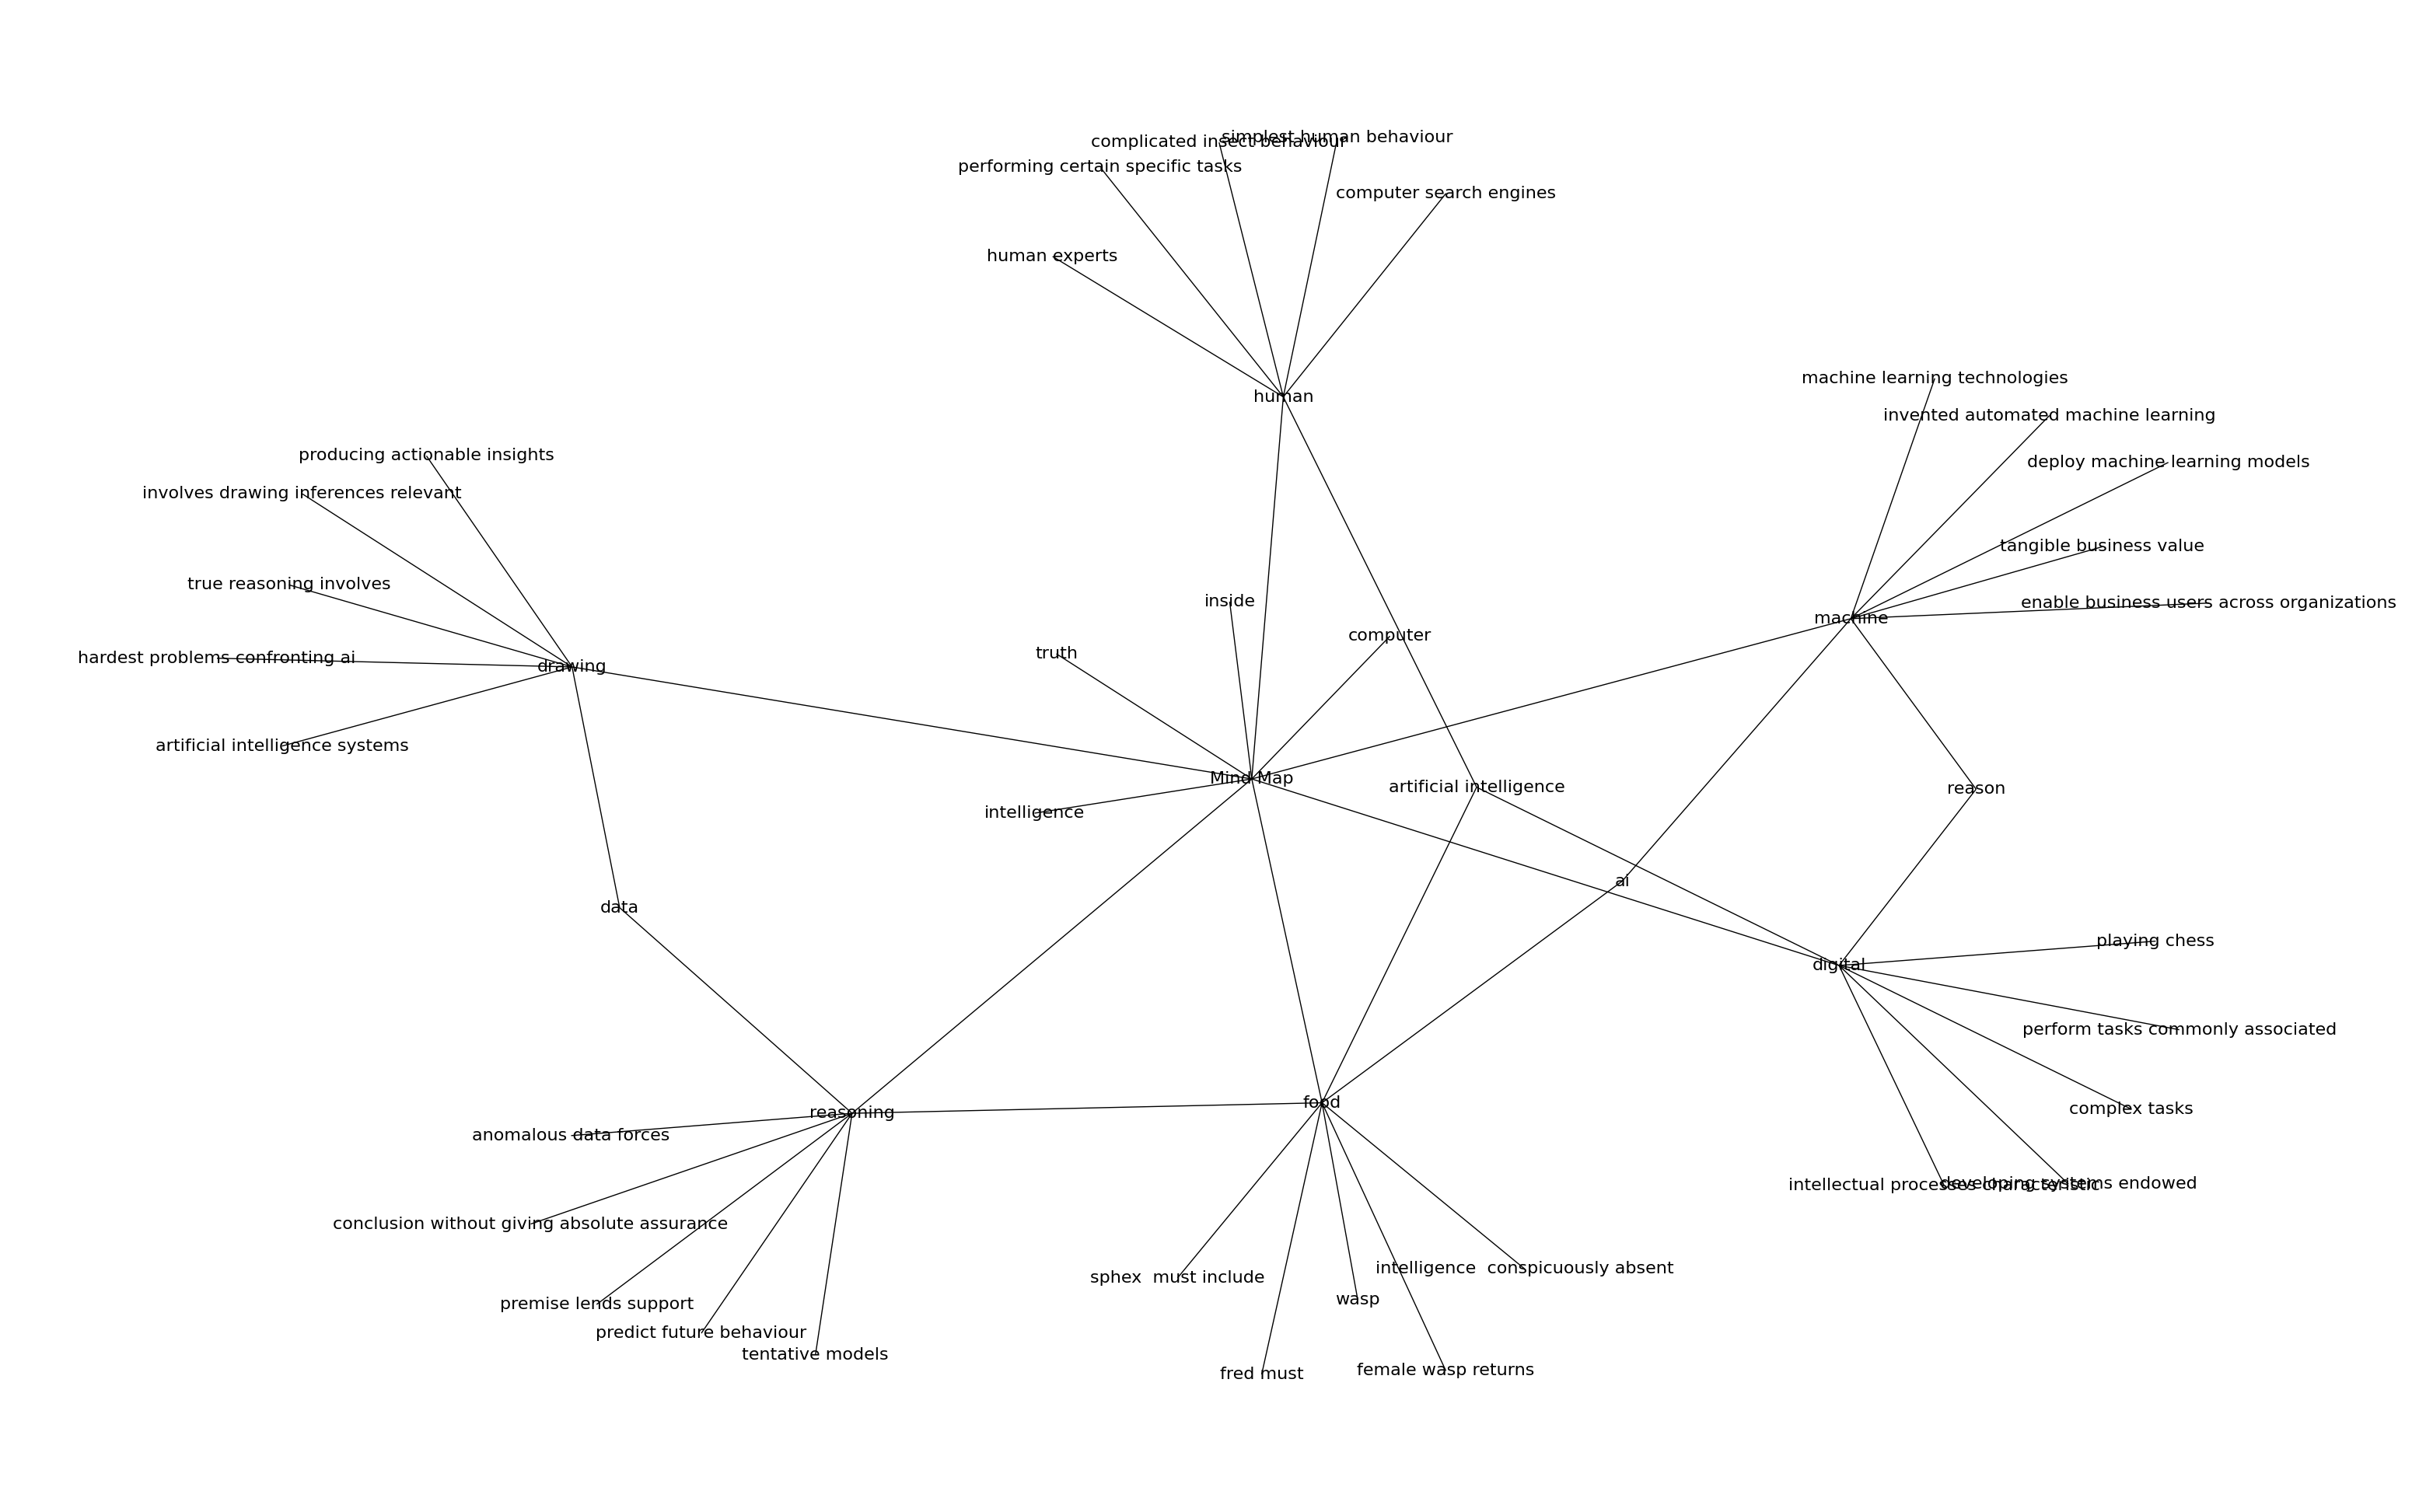

In [30]:
final_text = load_text(r"C:\Users\manig\Downloads\MM Data\sample_text.txt")
keywords2, topics2 = create_keywords_from_text(final_text, max_nodes=5, sentence_group=4)
get_mindmap(keywords2, topics2)

### Test - 3 (Web Scrapping)

In [31]:
scraped_data = scrape_data('https://en.wikipedia.org/wiki/Wikipedia:About')
final_text = clean_text(scraped_data)
summary = generate_summary(final_text, top_n=40)
summary

"Anyone can edit Wikipedia 's text , references , and images . Because anyone can improve Wikipedia , it has become more comprehensive , clear , and balanced than any other encyclopedia . Since its creation on January 15 , 2001 , Wikipedia has grown into the world 's largest reference website , attracting over a billion visitors monthly . Hosted by the Wikimedia Foundation , Wikipedia consists of freely editable content , whose articles also have numerous links to guide readers to more information . Editors ' opinions , beliefs , personal experiences , unreviewed research , libelous material , and copyright violations will not remain . The content must conform with Wikipedia 's policies , including being verifiable by published sources . Its contributors improve the quality and quantity of the articles as well as remove misinformation , errors , and vandalism . Wikipedia 's software allows easy reversal of errors , and experienced editors watch and patrol bad edits . The Wikipedia comm

<module 'matplotlib.pyplot' from 'C:\\Users\\manig\\anaconda3\\envs\\nlp\\lib\\site-packages\\matplotlib\\pyplot.py'>

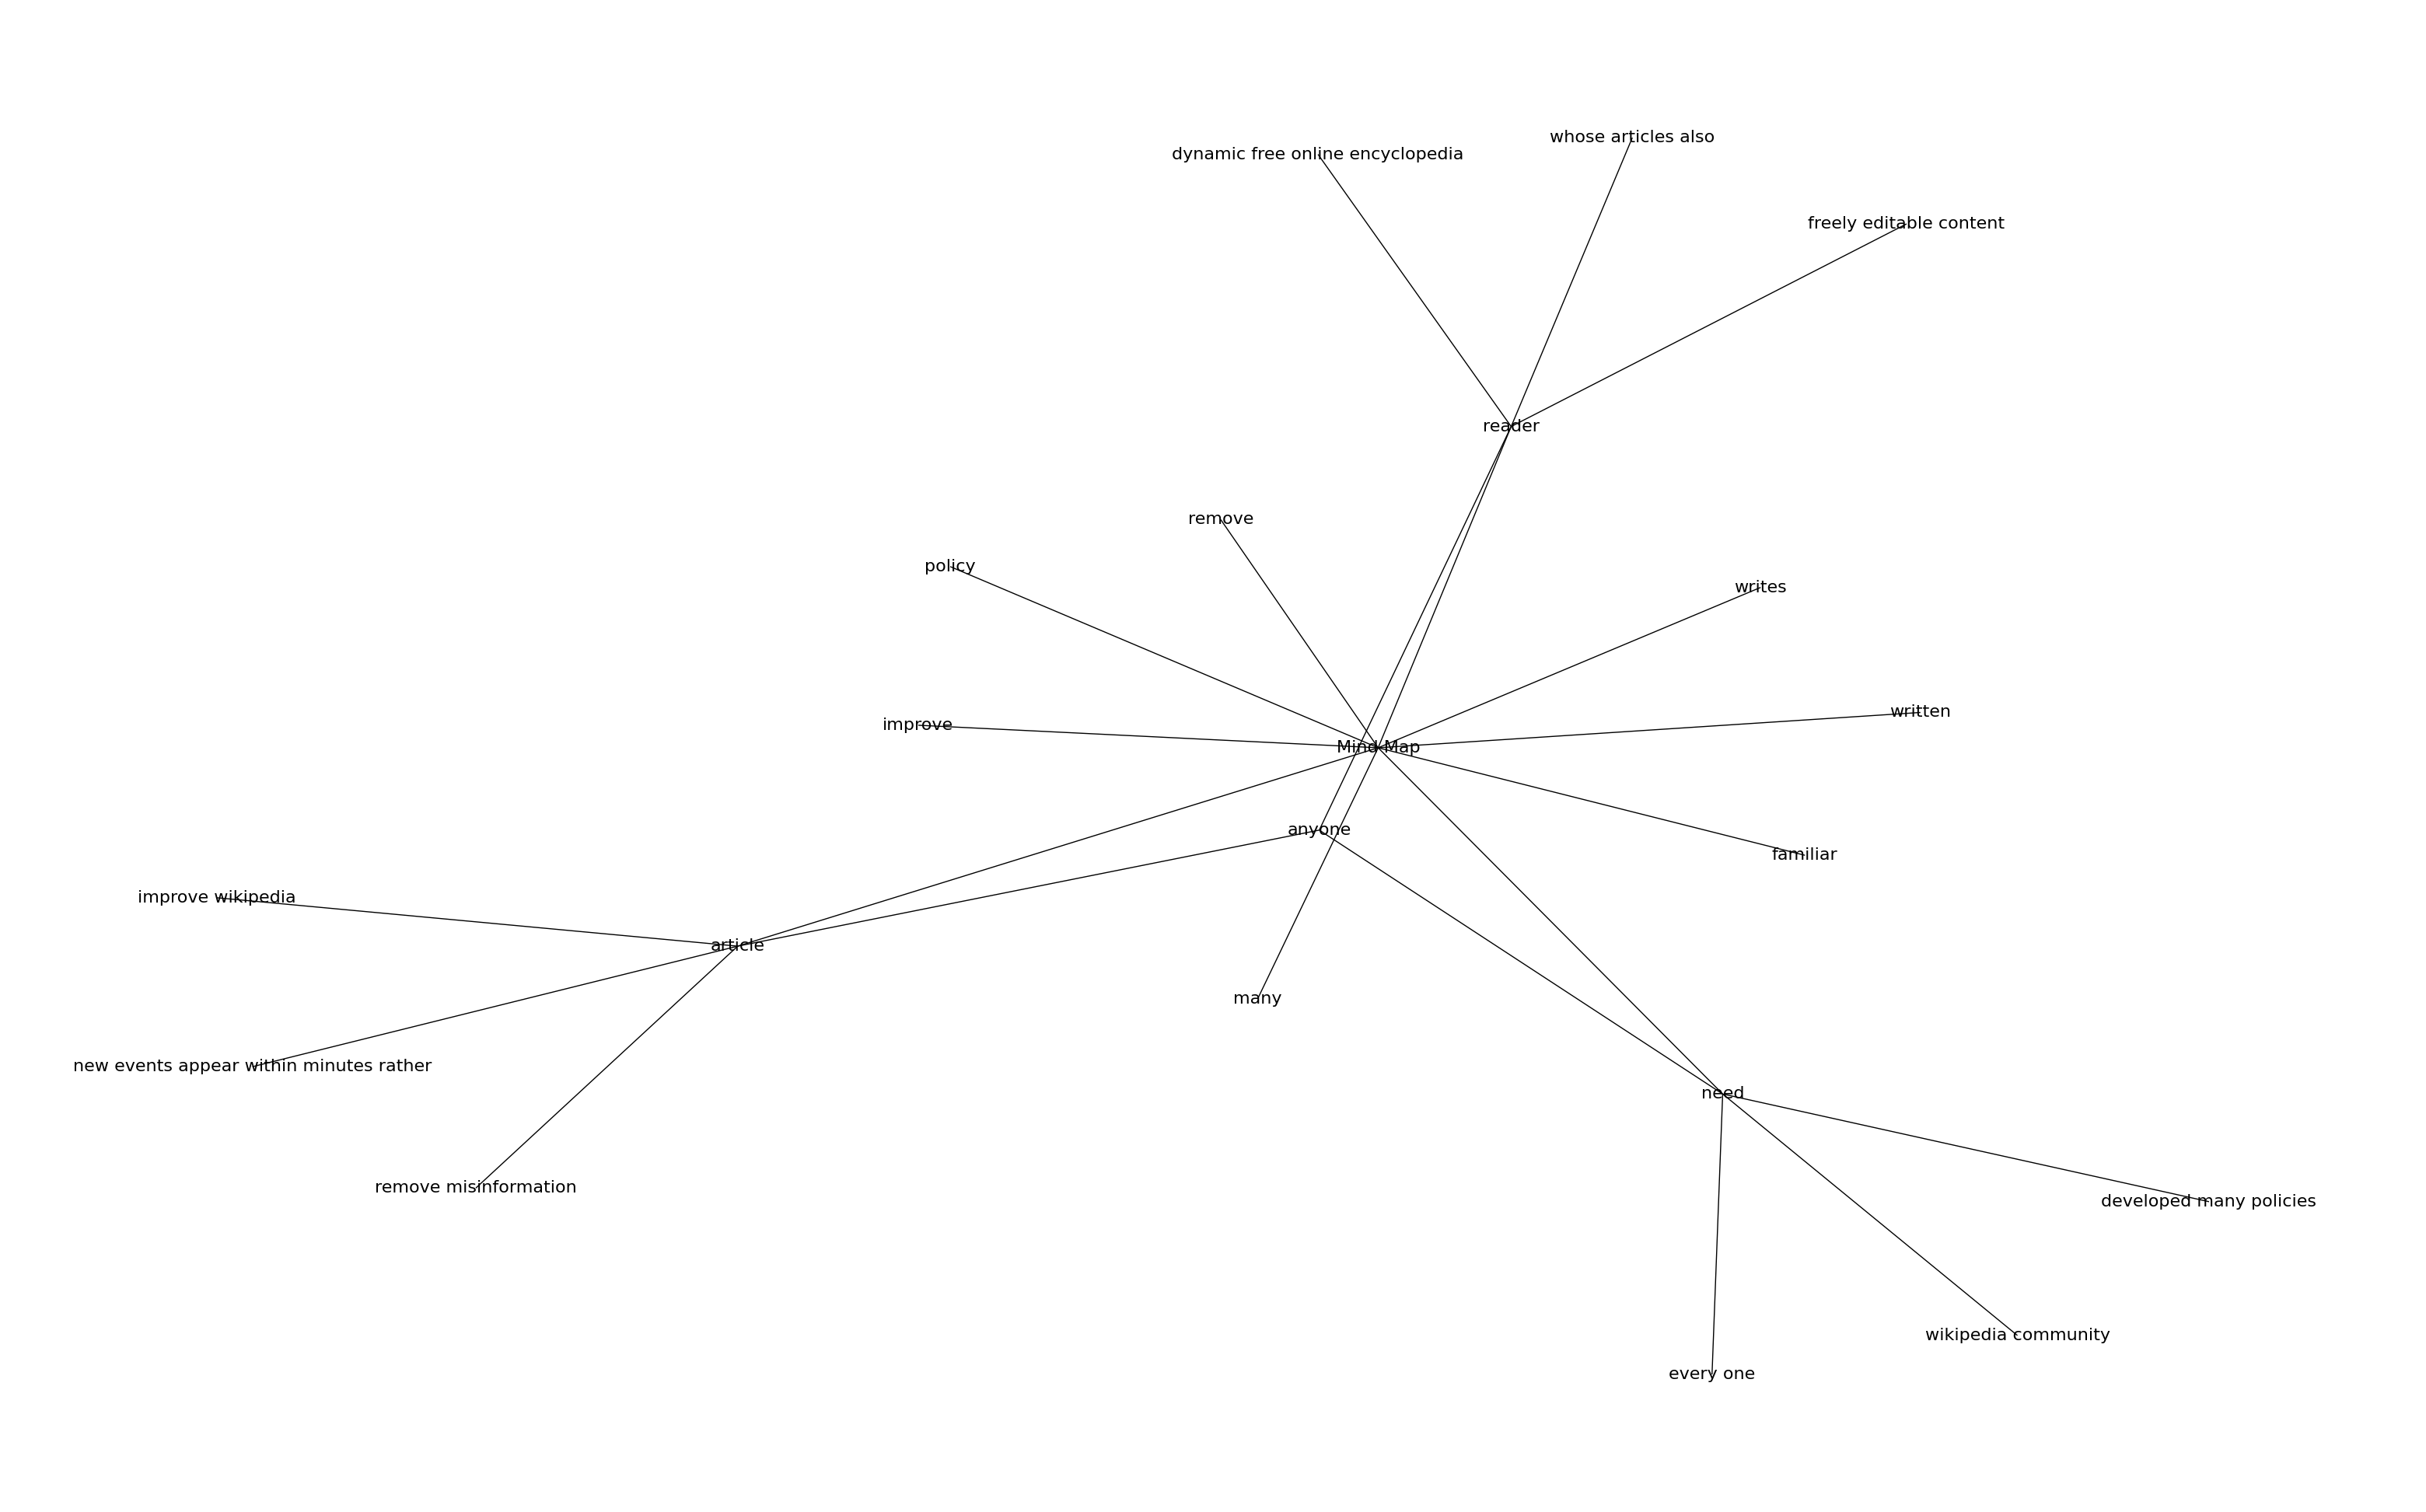

In [32]:
keywords2, topics2 = create_keywords_from_text(final_text, max_nodes=3, sentence_group=7)
get_mindmap(keywords2, topics2)